In [595]:
import pandas as pd
import umap
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score, cross_val_predict, LeaveOneOut, KFold
from sklearn.svm import SVC
# from hypopt import GridSearch

from sklearn.preprocessing import OneHotEncoder

from umap import UMAP
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA, FastICA
# import psyplot.project as psy
from sklearn.svm import SVR

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap

from matplotlib.colors import LogNorm
import math

from scipy.stats import mannwhitneyu

In [596]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/ScCal-SLi_right"
model_path = glob.glob(f"{path}/*")[0]
ukb_emb_file = f"{model_path}/cadasil_random_embeddings/full_embeddings.csv"
print(ukb_emb_file)



/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/ScCal-SLi_right/name07-54-42_78/cadasil_random_embeddings/full_embeddings.csv


In [597]:
participants_file = "/neurospin/dico/data/human/cadasil/participants.tsv"
participants = pd.read_csv(participants_file, sep='\t', index_col=0)
participants = participants.reset_index()
participants.head()

,Subject,Category,participant_id,session
0,010-RG,Control,rv_BIOMRI_CADA_001_010_RG_S3_3DT1_mprage_1iso_...,1
1,011-BK,Control,rv_BIOMRI_CADA_001_011_BK_S3_3DT1_mprage_1iso_...,1
2,012-TE,Patient,rv_BIOMRI_CADA_001_012_TE_S3_3DT1_mprage_1iso_...,1
3,012-TE,Patient,rv_BIOMRI_CADA_001_012_TE_2_S5_3DT1_mprage_1is...,2
4,014-LV,Control,rv_BIOMRI_CADA_001_014_LV_S3_3DT1_mprage_1iso_...,1


In [598]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb = ukb_emb.reset_index()
ukb_emb.head()

,ID,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32
0,rv_BIOMRI_CADA_001_010_RG_S3_3DT1_mprage_1iso_...,-15.741159,31.976582,-76.209380,132.455000,13.502833,-15.035481,26.796660,-10.820212,-19.518322,...,28.454443,27.329315,-23.517100,-16.227634,28.623854,-46.016594,-14.148274,16.159557,-41.162400,-25.375286
1,rv_BIOMRI_CADA_001_011_BK_S3_3DT1_mprage_1iso_...,7.032745,44.623750,-33.889828,71.731930,31.988590,-16.937115,-26.548700,7.197096,18.731678,...,36.534985,20.136866,-22.633043,-14.572310,-30.081367,21.420301,-42.622260,18.037113,36.734627,-8.343766
2,rv_BIOMRI_CADA_001_012_TE_2_S5_3DT1_mprage_1is...,0.667809,15.951781,-12.976472,79.010010,27.798208,29.916710,-18.878748,-33.241623,-1.116767,...,-26.393480,-36.375076,3.522615,19.221169,-48.765915,31.442728,-5.095129,-32.760624,63.032776,11.338992
3,rv_BIOMRI_CADA_001_012_TE_S3_3DT1_mprage_1iso_...,-11.804127,23.806545,-4.818307,58.885174,27.051958,23.346548,-19.869947,-23.376800,-4.153165,...,-5.226627,-35.057137,9.791383,6.708715,-46.131850,19.293306,1.300398,-18.755669,53.912067,14.241803
4,rv_BIOMRI_CADA_001_014_LV_S3_3DT1_mprage_1iso_...,11.776239,7.066210,-40.515583,-37.377370,-22.413689,30.016283,-12.600651,30.099874,16.732134,...,-2.350255,-29.605831,47.377033,-28.498846,-46.385883,36.686466,3.634396,3.986848,-6.338018,-1.508927


In [599]:
merged = participants.merge(ukb_emb, left_on='participant_id', right_on='ID')
merged = merged[merged.session==1]
merged = merged.set_index('Subject').drop(['ID', 'participant_id', 'session'], axis=1)
merged.head()

,Category,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32
Subject,,,,,,,,,,,,,,,,,,,,,
010-RG,Control,-15.741159,31.976582,-76.209380,132.455000,13.502833,-15.035481,26.796660,-10.820212,-19.518322,...,28.454443,27.329315,-23.517100,-16.227634,28.623854,-46.016594,-14.148274,16.159557,-41.162400,-25.375286
011-BK,Control,7.032745,44.623750,-33.889828,71.731930,31.988590,-16.937115,-26.548700,7.197096,18.731678,...,36.534985,20.136866,-22.633043,-14.572310,-30.081367,21.420301,-42.622260,18.037113,36.734627,-8.343766
012-TE,Patient,-11.804127,23.806545,-4.818307,58.885174,27.051958,23.346548,-19.869947,-23.376800,-4.153165,...,-5.226627,-35.057137,9.791383,6.708715,-46.131850,19.293306,1.300398,-18.755669,53.912067,14.241803
014-LV,Control,11.776239,7.066210,-40.515583,-37.377370,-22.413689,30.016283,-12.600651,30.099874,16.732134,...,-2.350255,-29.605831,47.377033,-28.498846,-46.385883,36.686466,3.634396,3.986848,-6.338018,-1.508927
017-LE,Patient,-2.904176,37.790520,-49.624626,108.826900,28.329775,26.048630,-22.469835,-33.090183,9.786113,...,14.685707,-6.807463,-48.765938,23.642927,-37.704124,16.216990,-36.862408,-11.882260,61.816727,17.444784


In [600]:
ukb_emb = merged.iloc[:,1:]
label   = merged.iloc[:,[0]]
ukb_emb.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim23,dim24,dim25,dim26,dim27,dim28,dim29,dim30,dim31,dim32
Subject,,,,,,,,,,,,,,,,,,,,,
010-RG,-15.741159,31.976582,-76.209380,132.455000,13.502833,-15.035481,26.796660,-10.820212,-19.518322,-47.348087,...,28.454443,27.329315,-23.517100,-16.227634,28.623854,-46.016594,-14.148274,16.159557,-41.162400,-25.375286
011-BK,7.032745,44.623750,-33.889828,71.731930,31.988590,-16.937115,-26.548700,7.197096,18.731678,-10.416293,...,36.534985,20.136866,-22.633043,-14.572310,-30.081367,21.420301,-42.622260,18.037113,36.734627,-8.343766
012-TE,-11.804127,23.806545,-4.818307,58.885174,27.051958,23.346548,-19.869947,-23.376800,-4.153165,-62.077156,...,-5.226627,-35.057137,9.791383,6.708715,-46.131850,19.293306,1.300398,-18.755669,53.912067,14.241803
014-LV,11.776239,7.066210,-40.515583,-37.377370,-22.413689,30.016283,-12.600651,30.099874,16.732134,-1.845092,...,-2.350255,-29.605831,47.377033,-28.498846,-46.385883,36.686466,3.634396,3.986848,-6.338018,-1.508927
017-LE,-2.904176,37.790520,-49.624626,108.826900,28.329775,26.048630,-22.469835,-33.090183,9.786113,-71.786250,...,14.685707,-6.807463,-48.765938,23.642927,-37.704124,16.216990,-36.862408,-11.882260,61.816727,17.444784


In [601]:
label.head()

,Category
Subject,
010-RG,Control
011-BK,Control
012-TE,Patient
014-LV,Control
017-LE,Patient


# cadasil first analysis

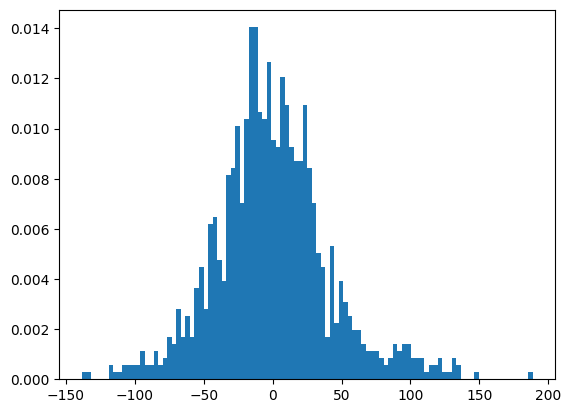

In [602]:
p = plt.hist(ukb_emb.values.ravel(), bins=100, density=True)

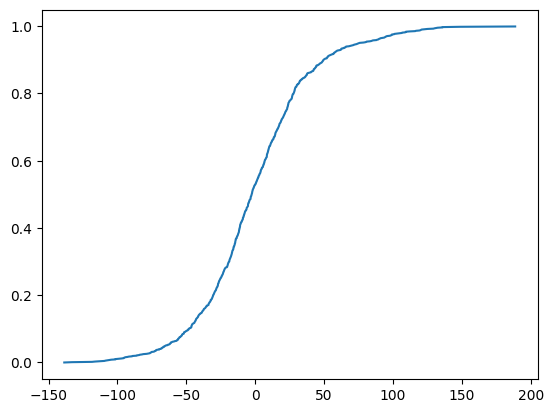

In [603]:
Z = ukb_emb.values.ravel()
N = len(Z)
X2 = np.sort(Z)
F2 = np.array(range(N))/float(N)

plt.plot(X2, F2)

In [604]:
X2[int(N*0.59)]

6.2920094

In [605]:
len(ukb_emb)

34

In [606]:
ukb_positive = (ukb_emb>0).sum(axis=0)/len(ukb_emb)
ukb_positive = ukb_positive.sort_values(ascending=False)

In [607]:
ukb_positive

dim16    1.000000
dim17    0.970588
dim4     0.941176
dim15    0.882353
dim31    0.882353
dim28    0.823529
dim5     0.823529
dim23    0.764706
dim11    0.647059
dim24    0.647059
dim2     0.529412
dim19    0.500000
dim7     0.500000
dim6     0.500000
dim13    0.411765
dim21    0.382353
dim32    0.352941
dim20    0.352941
dim8     0.352941
dim25    0.323529
dim30    0.323529
dim1     0.323529
dim26    0.294118
dim9     0.264706
dim18    0.264706
dim22    0.235294
dim3     0.205882
dim10    0.176471
dim29    0.176471
dim27    0.117647
dim14    0.088235
dim12    0.000000
dtype: float64

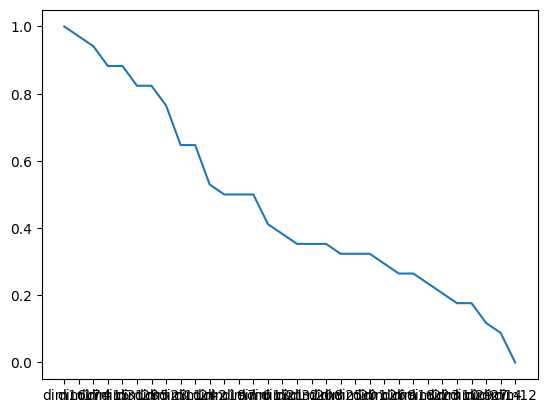

In [608]:
plt.plot(ukb_positive)

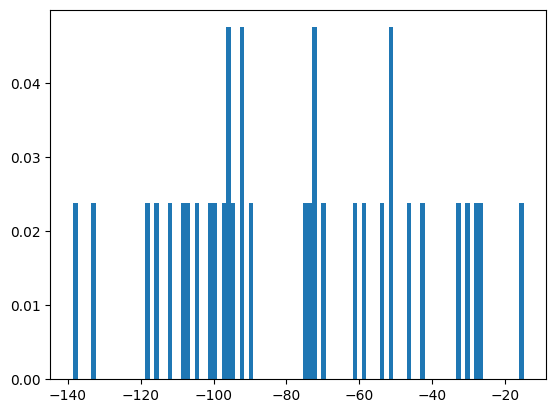

In [609]:
p = plt.hist(ukb_emb.loc[:,"dim12"], bins=100, density=True)

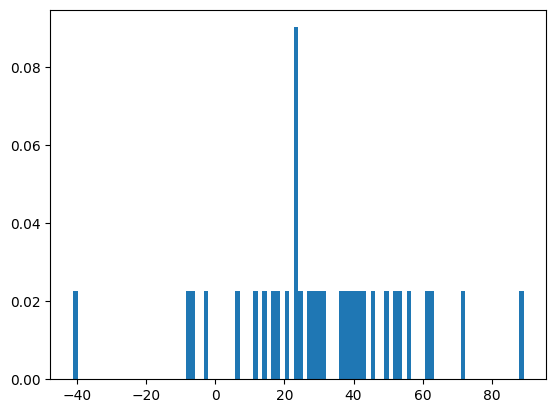

In [610]:
p = plt.hist(ukb_emb.loc[:,"dim31"], bins=100, density=True)

# Plotting functions

In [611]:
color_dict = {'Control': 'black', 'Patient': 'red'}
palette_boxplot = {'Control': 'skyblue', 'Patient': 'orange'}

In [612]:
def plot_scatter(df):
    plt.scatter(df[:,0], df[:,1], c=merged.Category.map(color_dict), s=10, alpha=1)

In [613]:
def do_mannwhitneyu(entree, nom="target"):
    df = label.copy()
    df[nom] = entree
    U1, p = mannwhitneyu(df[df.Category=='Control'][nom], df[df.Category=='Patient'][nom], method="exact")
    p = float(f'{p:.{2}g}')
    return p

In [614]:
def plot_box(entree, nom, ax):
    df = label.copy()
    df[nom] = entree
    sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)
    sns.stripplot(data=df, x='Category', y=nom, color='black', ax=ax)
    ax.get_yaxis().set_ticks([])
    ax.text(0.8, 0.9, s=f'p = {do_mannwhitneyu(entree)}', transform=ax.transAxes)

# ISOMAP

In [615]:
def compute_isomap(df):
    iso = Isomap(n_components=2)
    visual_isomap = iso.fit_transform(df)
    return visual_isomap

In [616]:
visual_isomap = compute_isomap(ukb_emb)

In [617]:
do_mannwhitneyu(visual_isomap[:,0])

0.014

/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)


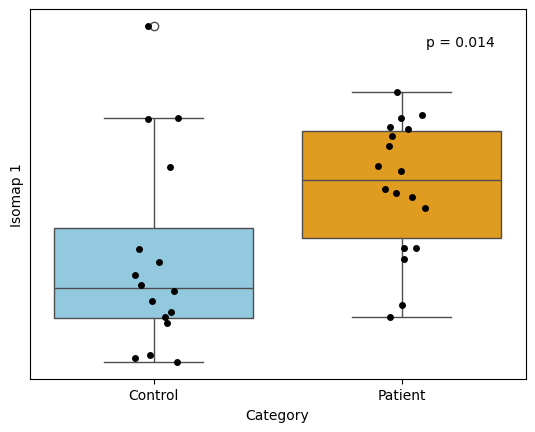

In [618]:
fig, ax = plt.subplots(1, 1)
plot_box(visual_isomap[:,0], "Isomap 1", ax)

# UMAP

In [619]:
def compute_umap(df, n_neighbors=15, n_components=2):
    # apply umap
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [620]:
visual_ukb_emb, reducer = compute_umap(ukb_emb, n_neighbors=5)

/volatile/jc225751/Runs/82_V1_after_ablation/Program/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)


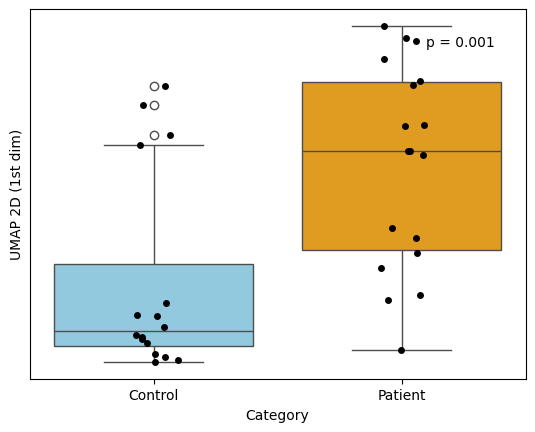

In [621]:
fig, ax = plt.subplots(1, 1)
plot_box(visual_ukb_emb[:,0], "UMAP 2D (1st dim)", ax)

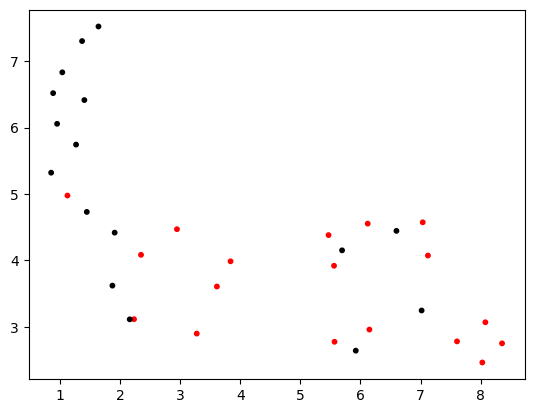

In [622]:
plt.scatter(visual_ukb_emb[:,0], visual_ukb_emb[:,1], c=merged.Category.map(color_dict), s=10, alpha=1)

In [623]:
reduced_ukb_emb, reducer_red = compute_umap(ukb_emb, n_neighbors=5, n_components=3)

/volatile/jc225751/Runs/82_V1_after_ablation/Program/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)


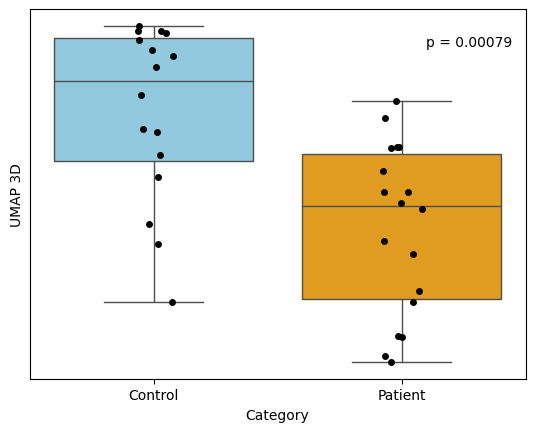

In [624]:
fig, ax = plt.subplots(1, 1)
plot_box(reduced_ukb_emb[:,0], "UMAP 3D", ax)

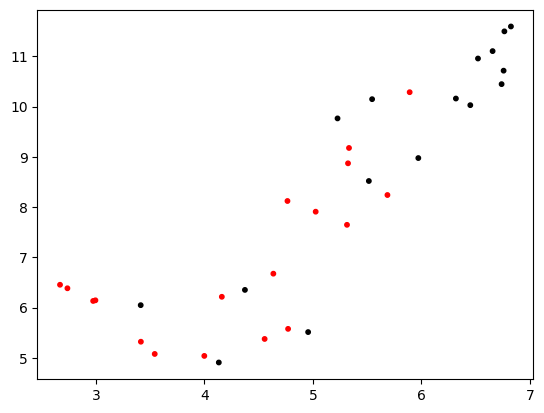

In [625]:
plt.scatter(reduced_ukb_emb[:,0], reduced_ukb_emb[:,1], c=merged.Category.map(color_dict), s=10, alpha=1)

# PCA

In [626]:
my_model = PCA(n_components=20)
on_axes_PCA = my_model.fit_transform(ukb_emb)
explained_all = my_model.explained_variance_ratio_.cumsum()

/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)


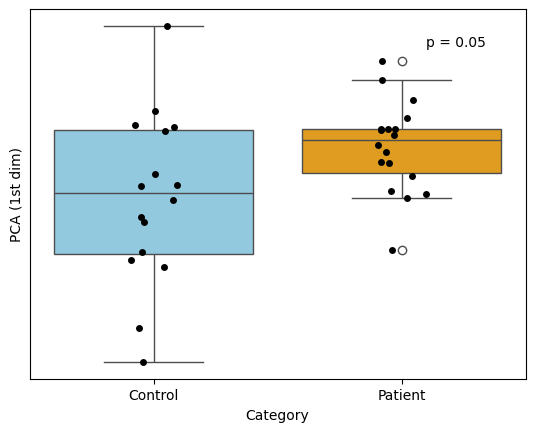

In [627]:
fig, ax = plt.subplots(1, 1)
plot_box(on_axes_PCA[:,0], "PCA (1st dim)", ax)

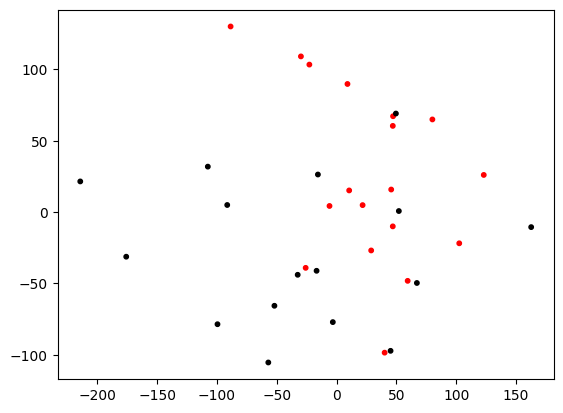

In [628]:
plt.scatter(on_axes_PCA[:,0], on_axes_PCA[:,1], c=merged.Category.map(color_dict), s=10)

In [629]:
reduced_ukb_emb.shape

(34, 3)

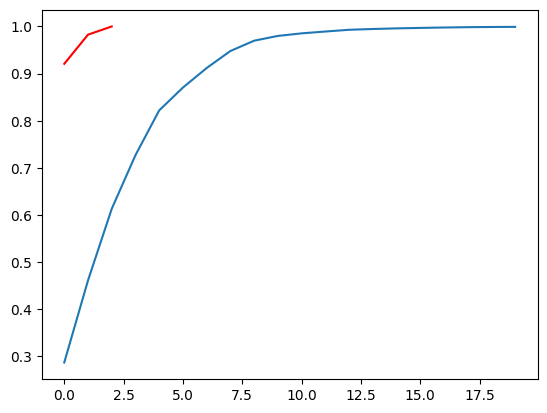

In [630]:
my_model = PCA(n_components=3)
on_axes = my_model.fit_transform(reduced_ukb_emb)
explained = my_model.explained_variance_ratio_.cumsum()
plt.plot(explained, 'r')
plt.plot(explained_all)
plt.show()

In [631]:
explained

array([0.92075187, 0.9826414 , 1.        ], dtype=float32)

In [632]:
explained_all

array([0.28721113, 0.4612259 , 0.61314736, 0.72703391, 0.82193527,
       0.87043278, 0.91184111, 0.94796382, 0.96982484, 0.97996011,
       0.9854173 , 0.9892842 , 0.99300578, 0.99465206, 0.99596618,
       0.99694826, 0.99782291, 0.99851267, 0.99891425, 0.99918429])

In [633]:
on_axes.shape

(34, 3)

/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)


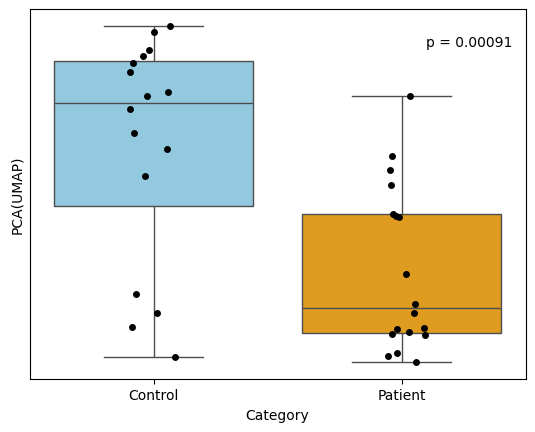

In [634]:
fig, ax = plt.subplots(1, 1)
plot_box(on_axes[:,0], "PCA(UMAP)", ax)

In [635]:
on_axes[:,0]

array([ 1.706439  ,  3.019947  , -2.5182223 ,  3.8855276 ,  0.907259  ,
       -1.9684753 , -3.0907035 , -3.028181  , -2.5047598 ,  1.2217169 ,
       -0.02689075,  2.2305403 , -2.6245108 ,  3.21939   , -2.1730895 ,
       -0.10534763, -1.3390164 ,  4.020376  , -3.1133537 , -3.2280006 ,
        0.5923672 , -1.765769  , -2.5788765 ,  2.4980946 , -2.6562033 ,
        1.3696728 , -0.07923126, -2.1762457 , -2.4723415 ,  3.4948845 ,
        2.5161629 ,  3.3794947 ,  2.6052208 ,  0.7821121 ], dtype=float32)

/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)
/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)
/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', palette=palette_boxplot, y=nom, ax=ax)
/tmp/ipykernel_2087453/937727531.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is depre

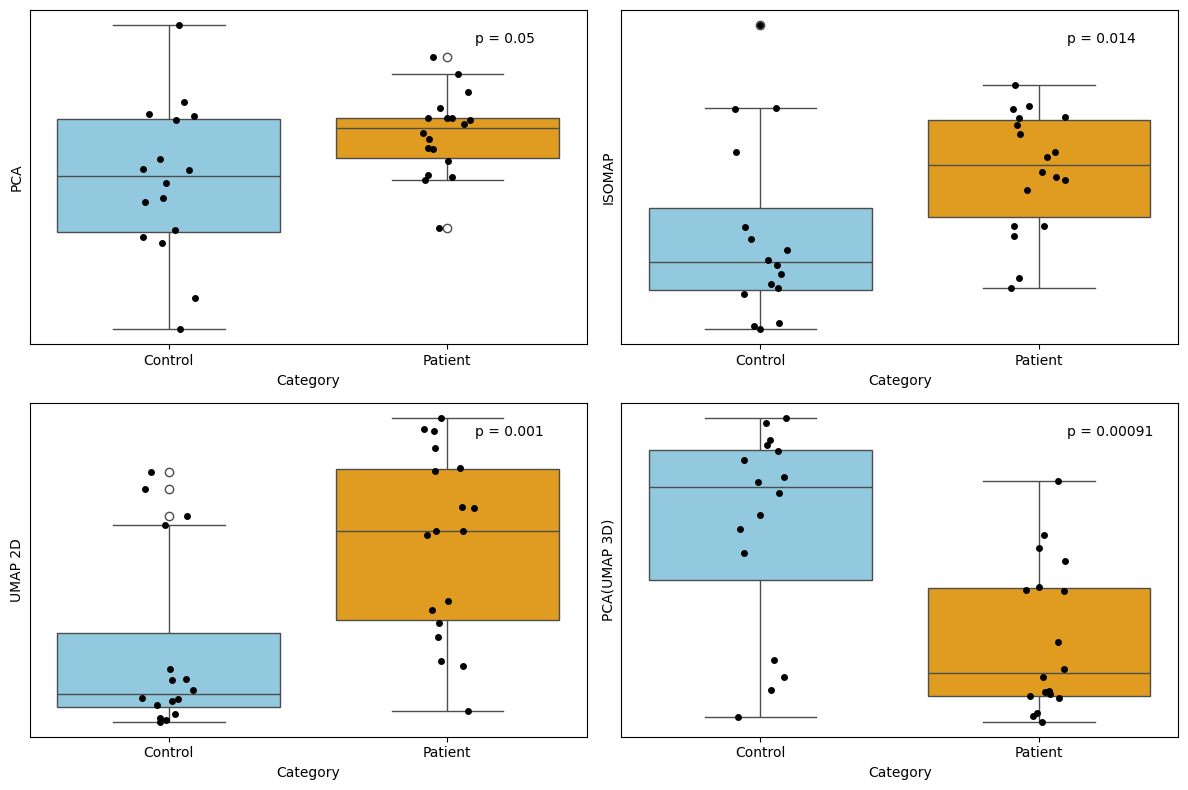

In [636]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
plot_box(on_axes_PCA[:,0], "PCA", axes[0,0])
plot_box(visual_isomap[:,0], "ISOMAP", axes[0,1])
plot_box(visual_ukb_emb[:,0], "UMAP 2D", axes[1,0])
plot_box(on_axes[:,0], "PCA(UMAP 3D)", axes[1,1])
fig.tight_layout()

In [637]:
together = pd.DataFrame({'PCA': on_axes_PCA[:,0], 'ISOMAP': visual_isomap[:,0], 'UMAP 2D': visual_ukb_emb[:,0], 'PCA(UMAP 3D)': on_axes[:,0]})

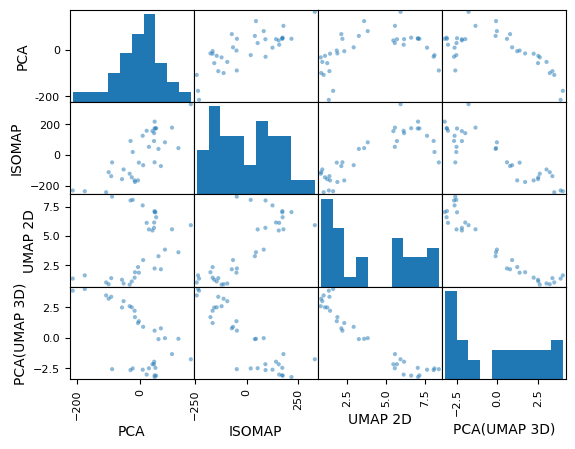

In [638]:
f = pd.plotting.scatter_matrix(together)